In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


### Non masked

In [3]:
loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"
model       = torch.load(
                   "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_16-11-2022_16h_37min_best_ValAcc_0.9938905859483477_epoch_9.pt")


loader = torch.load(loader_path).get_test_loader()




len(list(iter(loader.dataset)))


2401

In [4]:


explainer    = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)


model.eval()
gc.collect()
torch.cuda.empty_cache() 
edge_num           = loader.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in loader.dataset:
    _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
    
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))

Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 643.95it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

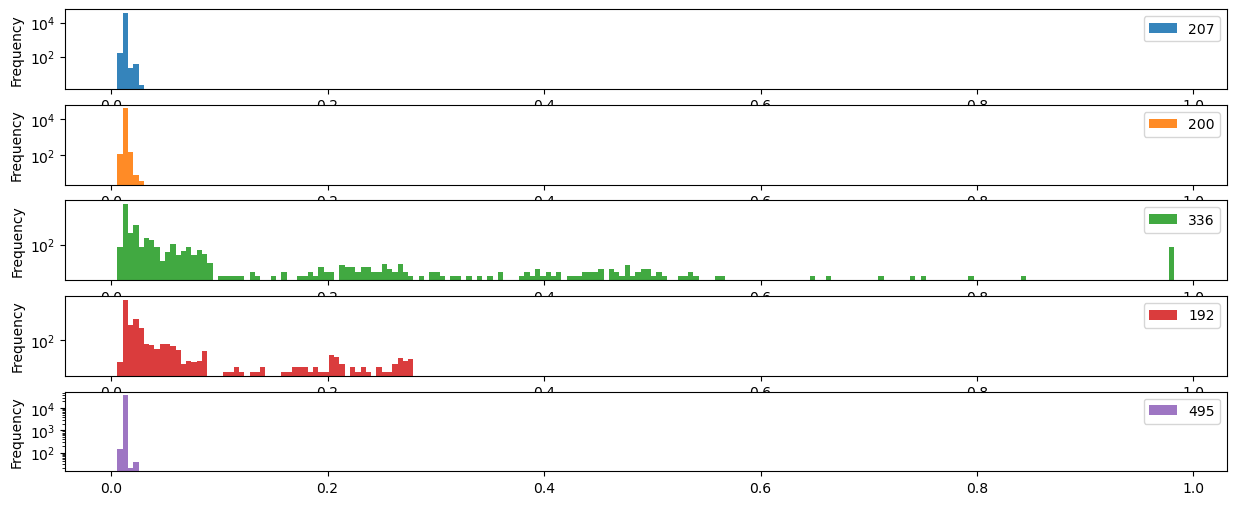

In [5]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


In [18]:
train_labels = []
for graph in tqdm.tqdm(loader.dataset):
    train_labels.append(graph.y.cpu().item())
assert train_labels.__len__() == all_graphs_weights_df.shape[1]
#all_graphs_weights.shape

labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
labels
pd.Series(labels).to_csv("./results/dataframes/Non_Masked_test_labels.csv")

all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
print(f"{all_graphs_weights_df.shape=}")
all_graphs_weights_df.to_parquet('./results/dataframes/Non_masked_graphs_weights_from_explainer.parquet.gzip', compression = 'gzip')

100%|██████████| 2401/2401 [00:00<00:00, 606694.61it/s]


all_graphs_weights_df.shape=(38428, 2401)


### Process explainer weights

((385, 2401), (38428,))

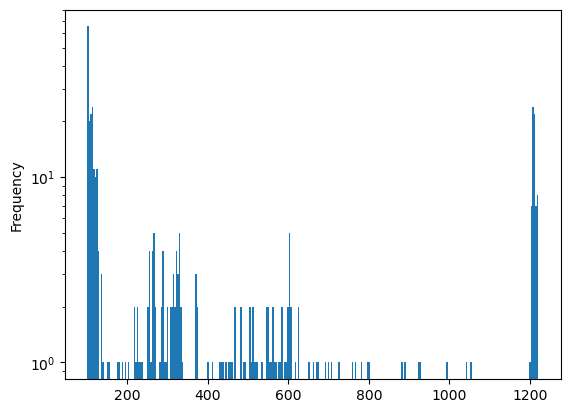

In [11]:
edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)


filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]

filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=300)
filtered_graph_weights_df.shape, edge_mask.shape

<AxesSubplot:ylabel='Frequency'>

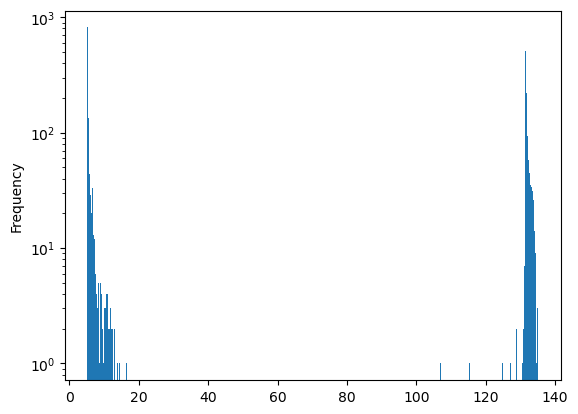

In [19]:
filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)


In [20]:
filtered_graph_weights = filtered_graph_weights_df.transpose() 
filtered_graph_weights["Label"] = list(labels)

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights

,4,151,170,171,173,335,428,583,924,925,...,37871,38015,38219,38276,38279,38312,38314,38315,38319,Label
0,0.010364,0.013913,0.013917,0.014826,0.014486,0.013833,0.013895,0.013694,0.012513,0.013330,...,0.013305,0.013770,0.013744,0.013735,0.013863,0.013388,0.014078,0.011851,0.013296,Control
1,0.973281,0.395449,0.711719,0.978887,0.738554,0.353051,0.084491,0.343454,0.981893,0.073243,...,0.065605,0.210323,0.089593,0.866092,0.745213,0.074007,0.088870,0.981878,0.074898,PKU
2,0.008578,0.014437,0.015004,0.017719,0.016355,0.014404,0.014855,0.014449,0.013834,0.013628,...,0.013290,0.014390,0.014253,0.014638,0.014783,0.012805,0.014560,0.011315,0.013616,Control
3,0.981670,0.441639,0.539293,0.979795,0.251163,0.382657,0.086073,0.347651,0.982174,0.080869,...,0.069022,0.239438,0.142807,0.808083,0.610934,0.080938,0.089456,0.982174,0.081269,PKU
4,0.010527,0.013735,0.013928,0.014306,0.014551,0.013769,0.014096,0.013929,0.012378,0.013324,...,0.013313,0.013885,0.013846,0.013865,0.013953,0.013328,0.013996,0.011960,0.013297,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,0.011705,0.013623,0.013914,0.013488,0.013952,0.013623,0.013850,0.013660,0.012521,0.013421,...,0.013192,0.013821,0.013557,0.013829,0.013825,0.013337,0.013875,0.012054,0.013286,Control
2397,0.011981,0.013565,0.013647,0.013140,0.013634,0.013555,0.013746,0.013519,0.012493,0.013361,...,0.013356,0.013562,0.013511,0.013491,0.013502,0.013248,0.013798,0.012376,0.013365,Control
2398,0.981386,0.462284,0.461872,0.980907,0.165406,0.426698,0.085594,0.397145,0.982362,0.081726,...,0.069621,0.234113,0.194887,0.742351,0.498086,0.080995,0.086236,0.982354,0.084094,PKU
2399,0.035208,0.027120,0.029577,0.147013,0.167457,0.025726,0.030402,0.025235,0.039554,0.040571,...,0.075960,0.025829,0.017413,0.045092,0.028798,0.040436,0.024030,0.039923,0.039829,Control


In [21]:
PYG_graph = torch.load("./results/graphs/PYG_graph_Concen_plus_Fluxes.pt")
NX_graph  = nx.read_gpickle("./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")
edge_0_node_idxs =  PYG_graph.edge_index[0,:]
edge_1_node_idxs =  PYG_graph.edge_index[1,:]
edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]

edges_node_names_explainer_subgraphs


,node1,node2,0,1,2,3,4,5,6,7,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
4,r1622,phe_L_e,0.010364,0.973281,0.008578,0.981670,0.010527,0.010533,0.007768,0.979904,...,0.011289,0.975524,0.967636,0.010913,0.009823,0.011705,0.011981,0.981386,0.035208,0.981847
151,r1898,ile_L_e,0.013913,0.395449,0.014437,0.441639,0.013735,0.013762,0.014078,0.435534,...,0.013836,0.331057,0.302477,0.013736,0.014439,0.013623,0.013565,0.462284,0.027120,0.436932
170,LEUPHELAT2tc,leu_L_e,0.013917,0.711719,0.015004,0.539293,0.013928,0.014004,0.014572,0.542999,...,0.013941,0.842872,0.695234,0.013993,0.014785,0.013914,0.013647,0.461872,0.029577,0.542636
171,LEUPHELAT2tc,phe_L_e,0.014826,0.978887,0.017719,0.979795,0.014306,0.014595,0.017169,0.979072,...,0.014876,0.974521,0.968630,0.014606,0.016835,0.013488,0.013140,0.980907,0.147013,0.979622
173,LEUPHELAT2tc,phe_L_c,0.014486,0.738554,0.016355,0.251163,0.014551,0.014249,0.015445,0.251144,...,0.014363,0.817997,0.642190,0.014253,0.015046,0.013952,0.013634,0.165406,0.167457,0.248580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38279,r1647,leu_L_e,0.013863,0.745213,0.014783,0.610934,0.013953,0.013934,0.014376,0.581509,...,0.013730,0.826704,0.787393,0.013822,0.014362,0.013825,0.013502,0.498086,0.028798,0.569893
38312,r1943,phe_L_c,0.013388,0.074007,0.012805,0.080938,0.013328,0.013275,0.013183,0.079052,...,0.013447,0.074184,0.078544,0.013381,0.013130,0.013337,0.013248,0.080995,0.040436,0.076916
38314,r1943,arg_L_e,0.014078,0.088870,0.014560,0.089456,0.013996,0.014103,0.014285,0.089088,...,0.014029,0.085810,0.086664,0.013979,0.014573,0.013875,0.013798,0.086236,0.024030,0.090156
38315,r1943,phe_L_e,0.011851,0.981878,0.011315,0.982174,0.011960,0.012033,0.011949,0.981899,...,0.012319,0.982039,0.980334,0.012165,0.012225,0.012054,0.012376,0.982354,0.039923,0.982113


In [22]:

edges_node_names_explainer_subgraphs.to_parquet(
    "./results/dataframes/Non_masked_edges_node_names_explainer_subgraphs.parquet.gzip", compression='gzip')